In [90]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [91]:
device = 'cuda'

In [92]:
batch_size = 256

class Custom:
    def __call__(self, x):
        return x*2-1

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Custom()
])

train = torchvision.datasets.MNIST(root='../../dataset/', train=True, transform=transform)
test = torchvision.datasets.MNIST(root='../../dataset/', train=False, transform=transform)

trainLoader = DataLoader(train, batch_size, shuffle=True, drop_last=True)
testLoader = DataLoader(test, batch_size, shuffle=False, drop_last=True)

In [93]:
class Generator(nn.Module):
	def __init__(self, d_noise, d_hidden):
		super(Generator, self).__init__()
		
		self.G = nn.Sequential(
			nn.Linear(d_noise, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, 28*28),
			nn.Tanh()
		)
	
	def forward(self, x):
		x = self.G(x)
		return x
	

class Discriminator(nn.Module):
	def __init__(self, d_noise, d_hidden):
		super(Discriminator, self).__init__()

		self.D = nn.Sequential(
			nn.Linear(28*28, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, 1),
			nn.Sigmoid()
		)
	
	def forward(self, x):
		x = self.D(x)
		return x

In [94]:
G = Generator(d_noise=100, d_hidden=256).to(device)
D = Discriminator(d_noise=100, d_hidden=256).to(device)

In [95]:
z = torch.randn(batch_size, 100).to('cuda')
img_fake = G(z).reshape(-1, 28, 28)

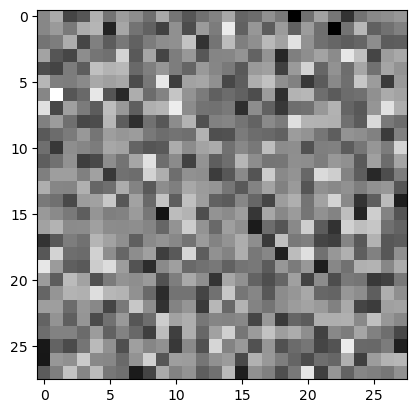

In [96]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img.detach()
    img = (img+1)/2
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

imshow(img_fake[0].cpu())

In [97]:
def make_z(batch_size, d_noise):
    return torch.randn(batch_size, d_noise, device=device)

In [98]:
loss_fn = nn.BCELoss()
lr = 10**-4

optim_G = torch.optim.Adam(params=G.parameters(), lr=lr)
optim_D = torch.optim.Adam(params=D.parameters(), lr=lr)

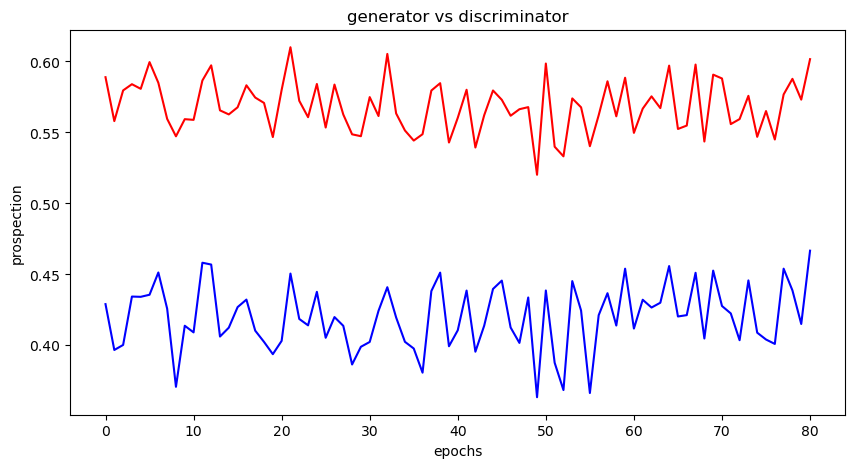

KeyboardInterrupt: 

In [166]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

n_epochs = 100
loss_gs = []
loss_ds = []

p_dis_eval = []
p_gen_eval = []

for epoch in range(n_epochs):
	for img, label in trainLoader:
		img, label = img.to(device), label.to(device)

		optim_D.zero_grad()
		p_real = D(img.reshape(-1, 28*28))
		p_fake = D(G(make_z(batch_size, 100)))
		loss_d = loss_fn(p_real, torch.ones_like(p_real).to(device)) + loss_fn(p_fake, torch.zeros_like(p_real).to(device))
		'''
		loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
		loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
		loss_d    = (loss_real + loss_fake).mean()
		'''
		loss_d.backward()
		optim_D.step()
		loss_ds.append(loss_d.item())


		optim_G.zero_grad()
		p_fake = D(G(make_z(batch_size, 100)))
		loss_g = loss_fn(p_fake, torch.ones_like(p_fake).to(device))
		'''
		loss_g = -1 * torch.log(p_fake).mean()
		'''
		loss_g.backward()
		optim_G.step()
		loss_gs.append(loss_g.item())
	
	if epoch==0:
		continue
	
	with torch.no_grad():
		p_dis = 0
		p_gen = 0
		for img, label in testLoader:
			img, label = img.to(device), label.to(device)

			p_real = D(img.reshape(-1, 28*28))
			p_fake = D(G(make_z(batch_size, 100)))
			p_dis += (torch.mean(p_real)).item()
			p_gen += (torch.mean(p_fake)).item()

		p_dis_eval.append(p_dis/len(testLoader))
		p_gen_eval.append(p_gen/len(testLoader))

		clear_output(wait=True)
		plt.figure(figsize=(10,5))
		plt.plot(p_dis_eval, color='red')
		plt.plot(p_gen_eval, color='blue')
		plt.xlabel('epochs')
		plt.ylabel('prospection')
		plt.title('generator vs discriminator')
		plt.show()


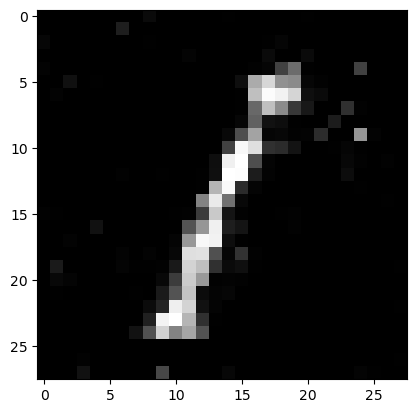

In [203]:
z = make_z(batch_size, 100)
z = G(z).cpu()

imshow(z[0].detach().reshape(28, 28))

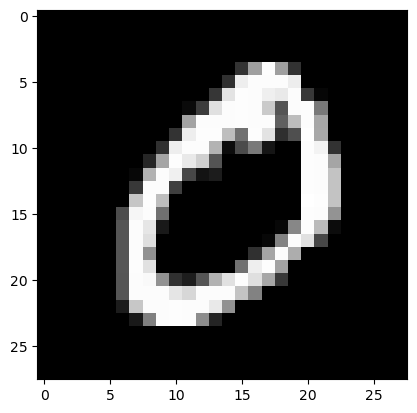

In [154]:
imshow(train[1][0].detach().reshape(28,28))